# Assignment 2: Data Preprocessing
## By: Cristian C Noriega M, Toyosi, Arshdeep Singh, Ang Dorje Sherpa


### Task:
Using Data Preprocessing technqiues on a chosen dataset to prepare it for future modeling/analysis

In [7]:
#cell for importing dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.cluster import hierarchy
import geopandas as gpd
import plotly.express as px
import folium
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA


from scipy.spatial.distance import euclidean

pd.set_option('display.max_rows', 35)

In [9]:
#Bringing in the two datasets we will be using and assigning them both to their own dataframe

df = pd.read_csv('world-data-2023.csv')
continent_df = pd.read_csv('Continent List.csv')

In [10]:
# Brief overview of the main dataset that shows name and datatype of columns and number of rows. 
# There are null values in pretty much every column. We will have to spend time fixing them as null values can cause issues later on.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    195 non-null    object 
 1   Density
(P/Km2)                           195 non-null    object 
 2   Abbreviation                               188 non-null    object 
 3   Agricultural Land( %)                      188 non-null    object 
 4   Land Area(Km2)                             194 non-null    object 
 5   Armed Forces size                          171 non-null    object 
 6   Birth Rate                                 189 non-null    float64
 7   Calling Code                               194 non-null    float64
 8   Capital/Major City                         192 non-null    object 
 9   Co2-Emissions                              188 non-null    object 
 10  CPI                        

In [11]:
# Shows the first five columns of the dataset, shows us what to expect for each column in terms of length, type, and scale of digits.
# We can see that there are numeric and alphabetical values. 

df.head()

,Country,Density\r\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


# DATA CLEANING
#### Rename columns, drop 2 columns, and 1 country. Drop countries where there are less than 25 Non-NA values 

In [12]:
#Renaming columns for two purposes. First, is to clean the names. Secondly, the $ shows that the values are standardized to USD and 
#the values in the rate columns are percentanges ('%')

df = df.rename(columns={'Density\n(P/Km2)':'Density(P/km2)','Total tax rate':'Total tax rate (%)',
                        'Minimum wage':'Minimum wage($)','Unemployment rate':'Unemployment rate(%)',
                        'Gasoline Price':'Gasoline Price($)','Out of pocket health expenditure':'Out of pocket health expenditure(%)'})

In [13]:
#Dropping columns that we will not need in our analysis 'Noisy data'.
#Also dropping the country (row) with its Latitude missing as we will be plotting a map later on.

df.drop(['Abbreviation','Calling Code'],axis=1,inplace=True) #columns not needed
df.drop(df[df['Latitude'].isna()].index,inplace=True)#drop country without Latitude - name was not able to be reconigzed


In [14]:
#Dropping any country/row that has less than 25 Non-NA values as this is way too little information to be useful in analysis 

df.dropna(axis=0,inplace=True,thresh=25)

In [15]:
# Re moving duplicates as they lead to Noisy Data, and will add skew to the data if there is more than one row per country.

duplicate = df[df.duplicated('Country')]
duplicate

,Country,Density\r\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude


#### Fill missing data

In [16]:
# Filling in the official language for the 4 countries, data was missing so we are doing it manually here. 

df.loc[df['Country'] == 'Australia', 'Official language'] ='English'
df.loc[df['Country'] == 'United States', 'Official language'] ='English'
df.loc[df['Country'] == 'Mexico', 'Official language'] ='Spanish'
df.loc[df['Country'] == 'Japan', 'Official language'] ='Japanese'

# Filling countries where there is no data about the capital city

df.loc[df['Country'] == 'Libya', 'Capital/Major City'] ='Tripoli'
df.loc[df['Country'] == 'Singapore', 'Capital/Major City'] ='Singapore'

# Filling null values for largest city by setting it equivalent to the country's capital city. 
# In most cases, the largest city is usually the capital, so this is an automated, although not 100% foolproof method of data cleaning. 

df['Largest city'].fillna(df['Capital/Major City'],inplace=True)

In [17]:
# Checking a few of the columns one by one to identify if there are any NaN values

df[df['Land Area(Km2)'].isna()]
df[df['Latitude'].isna()]
df[df['Official language'].isna()]
df[df['Capital/Major City'].isna()]
df[df['Agricultural Land( %)'].isna()]
df[df['Co2-Emissions'].isna()]
df[df['Unemployment rate(%)'].isna()]
df[df['Gasoline Price($)'].isna()]
df[df['Armed Forces size'].isna()]

,Country,Density\r\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude
38,Comoros,467,71.50%,"2,235",NaN,31.88,"Moroni, Comoros",202,103.62,-4.30%,...,74.80%,0.27,"850,886",43.30%,NaN,219.60%,4.34%,"248,152",-11.645500,43.333300
48,Dominica,96,33.30%,751,NaN,12.00,Roseau,180,103.87,1.00%,...,28.40%,1.08,"71,808",NaN,22.10%,32.60%,NaN,"50,830",15.414999,-61.370976
67,Grenada,331,23.50%,349,NaN,16.47,"St. George's, Grenada",268,107.43,0.80%,...,57.00%,1.41,"112,003",NaN,19.40%,47.80%,NaN,"40,765",12.116500,-61.679000
89,Kiribati,147,42.00%,811,NaN,27.89,South Tarawa,66,99.55,0.60%,...,0.20%,0.20,"117,606",NaN,22.00%,32.70%,NaN,"64,489",1.836898,-157.376832
107,Marshall Islands,329,63.90%,181,NaN,29.03,Majuro,143,NaN,NaN,...,10.00%,0.42,"58,791",NaN,17.80%,65.90%,NaN,"45,514",7.131474,171.184478
111,Federated States of Micronesia,784,31.40%,702,NaN,22.82,Palikir,143,112.1,0.50%,...,2.50%,0.18,"113,815",NaN,25.20%,60.50%,NaN,"25,963",7.425554,150.550812
132,Palau,39,10.90%,459,NaN,14.00,Ngerulmud,224,118.17,1.30%,...,21.80%,1.18,"18,233",NaN,21.30%,76.60%,NaN,"14,491",7.514980,134.582520
145,Saint Kitts and Nevis,205,23.10%,261,NaN,12.60,Basseterre,238,104.57,-1.00%,...,56.60%,2.52,"52,823",NaN,18.50%,49.70%,NaN,"16,269",17.357822,-62.782998
146,Saint Lucia,301,17.40%,616,NaN,12.00,Castries,414,110.13,1.90%,...,48.40%,0.64,"182,790",67.10%,18.20%,34.70%,20.71%,"34,280",13.909444,-60.978893
147,Saint Vincent and the Grenadines,284,25.60%,389,NaN,14.24,Kingstown,220,109.67,2.30%,...,21.40%,0.66,"100,455",65.90%,25.40%,37.00%,18.88%,"58,185",12.984305,-61.287228


In [18]:
# For the three columns below, we feel comfortable with the null values be set to 0. 
# Some of the countries have been researched online and the others most likely are 0 as well.

columns_to_check = ['Armed Forces size','Agricultural Land( %)','Co2-Emissions']

nan_rows = df[columns_to_check].isna().any(axis=1)

df.loc[nan_rows, columns_to_check] = 0

In [19]:
# Some attribute cleaning here as we remove characters so the columns can be converted from string/object to float numbers 

df = df.replace({',': ''}, regex=True)
df = df.replace({'$': ''}, regex=True)
df = df.replace({'%': ''}, regex=True)
df = df.replace({'[$,%]': ''}, regex=True)

df.fillna(0,inplace=True)

In [20]:
numeric_col = ['Density(P/km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Co2-Emissions', 'CPI', 'CPI Change (%)','Fertility Rate', 'Forested Area (%)', 'Gasoline Price($)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality','Life expectancy', 'Maternal mortality ratio', 'Minimum wage($)','Out of pocket health expenditure(%)', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate (%)', 'Unemployment rate(%)', 'Urban_population']
df[numeric_col] = df[numeric_col].astype(float)

KeyError: "['Density(P/km2)'] not in index"

In [ ]:
#Observing the summary statistics of our dataset. The range of the columns is wide so scaling might be needed to place every attribute on an equal playing field. 

df.describe()

In [ ]:
# Check for the number of NaN values by column

nan_counts = df.isna().sum()

print(nan_counts)

In [ ]:
# Merge the DataFrames on 'Country' to add the 'Continent' column. 
#This will bring in a new column that contains additional context and hierarchy in terms of geography

df = df.merge(continent_df, on='Country', how='left')
df[df['Continent'].isna()]

In [ ]:
# As shown above, there are some countries with a missing continent. To fill in the missing data, we will do it manually.

countries_to_update = ['The Bahamas','Republic of Ireland', 'North Korea', 'Russia','United Kingdom']

new_continents = ['North America', 'Europe', 'Asia','Europe','Europe']

for country, new_continent in zip(countries_to_update, new_continents):
    df.loc[df['Country'] == country, 'Continent'] = new_continent

In [ ]:
# We perform some categorical variable encoding by creating dummy varaibles. 
#As birth rate can changed based on continent, we transform that column into additional columns that have a Boolean data type. 
#This column describes which continent the country is in.
dummies = pd.get_dummies(df['Continent'], prefix='Continent')

# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df, dummies], axis=1)

# df

In [ ]:
#Checking the number of NaN values before we start creating vizzes. 

nan_counts = df.isna().sum()

print(nan_counts)

# VISUALIZATIONS

In [ ]:
#A look at the histogram for Birth Rate, the dependent variable we will be looking at. We can see shape (right skewed), and there does not appear to be any outliers.
#Most of the birth rates seem to be on the lower side, mostly betweeen the 6-25 range.

sns.histplot(data=df, x="Birth Rate")

In [ ]:
#We will create a correlation matrix to see how attributes correlate to each other. It will show, in a visual way, how columns relate. 

# Select only float columns
float_columns = df.select_dtypes(include=['float64'])

# Create a correlation matrix for the float columns
correlation_matrix = float_columns.corr()

In [ ]:
# We perform hierarchical clustering on the corr matrix to create a dendogram which visualizes the columns that are most alike. 
# In future assignments, we should pay attention to multi-collineearity when constructing models. Feertility Rate and Birth Rate seem to be highly correlated, which is logical.
# Fertility Rate might be a candidate to drop as it is highly correlated with the dependent in this case. 
# Life expectancy and the number of physicians seem to be highly negatively correlated, with some moderate negative correlations as well. 

linkage = hierarchy.linkage(correlation_matrix, method='average')
dendrogram = hierarchy.dendrogram(linkage, labels=correlation_matrix.columns, orientation='right')

# Reorder the columns based on clustering
ordered_columns = [correlation_matrix.columns[i] for i in dendrogram['leaves']]
ordered_corr_matrix = correlation_matrix.reindex(ordered_columns)[ordered_columns]

# Create a heatmap with reordered columns
plt.figure(figsize=(16, 10))  # Specify the figsize parameter to make the heatmap larger
sns.heatmap(ordered_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)


plt.title('Larger Correlation Matrix with Clustering')

plt.show()

### Scatterplot by birth rate and unemployment rate(%)

In [ ]:
# Using the continent information that we brought in from earlier, we can see that there are fairly clear clusters of Birth Rate by Continent.
# However, UE Rate does not seem to have a clear indicator on Birth Rate, telling us the job market may not have a huge influence. 

sns.scatterplot(data=df, x='Birth Rate', y='Unemployment rate(%)',hue='Continent')


plt.xlabel('Birth Rate')
plt.ylabel('Unemployment rate(%)')
plt.title('Scatterplot of Birth Rate vs Unemployment rate(%)')


plt.show()

In [21]:
# We create a scatterplot and lower the y-limit to $100B so we can clearly see more datapoints. Seems to be no real correlation here either. 
# Economic factors so far have shown not much indication on Birth Rate.

sns.scatterplot(data=df, x='Birth Rate', y='GDP',hue='Continent')


plt.xlabel('Birth Rate')
plt.ylabel('GDP')
plt.title('Scatterplot of Birth Rate vs GDP')
plt.ylim(0, 100000000000)

plt.show()

ValueError: Could not interpret value `Continent` for `hue`. An entry with this name does not appear in `data`.

In [ ]:
# We have seen above that Birth Rate and Continent have some sort of relationship. 
# The swarm plot shows each data point and upholds our thinking. Especially in the continents of Africa and Europe.


sns.swarmplot(data=df, x="Birth Rate",hue='Continent')

plt.title('Birth Rate')


plt.show()

In [ ]:
sns.swarmplot(data=df, x="Unemployment rate(%)",hue='Continent')

In [22]:
# Create a scatterplot
sns.scatterplot(data=df, x='GDP', y='Armed Forces size',hue='Continent')


plt.xlabel('GDP')
plt.ylabel('Armed Forces size')
plt.title('Scatterplot of GDP vs Armed Forces size')


plt.show()

ValueError: Could not interpret value `Continent` for `hue`. An entry with this name does not appear in `data`.

# Create a map

In [23]:
# Here we have created a map to show the Birth Rates, colored in by certain thresholds. It gives a global view on the values. 
# The Southern Hemisphere seems to have the higher birth rates than the North. While the Eastern Hemisphere has higher values than the West.

m = folium.Map(location=[0, 0], zoom_start=2)

# Iterate over rows in the DataFrame and add markers
for _, row in df.iterrows():
    country_name = row['Country']
    birth_rate = row['Birth Rate']
    latitude = row['Latitude']
    longitude = row['Longitude']

    # Customize marker color based on Birth Rate
    if birth_rate < 10:
        marker_color = 'green'
    elif 10 <= birth_rate < 15:
        marker_color = 'orange'
    else:
        marker_color = 'red'

    # Create markers for each country
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=6,
        color=marker_color,
        fill=True,
        fill_color=marker_color,
        fill_opacity=0.7,
        popup=f"{country_name}<br>Birth Rate: {birth_rate}",
    ).add_to(m)


In [24]:
m

## Visualizations by languages and continents

In [25]:
most_spoken_languages = df['Official language'].value_counts()
top_10_languages = most_spoken_languages.head(10)
top_10_languages.reset_index()

,Official language,count
0,English,31
1,French,24
2,Spanish,20
3,Arabic,17
4,Portuguese,7
5,Swahili,4
6,Russian,4
7,German,3
8,Italian,2
9,Persian,2


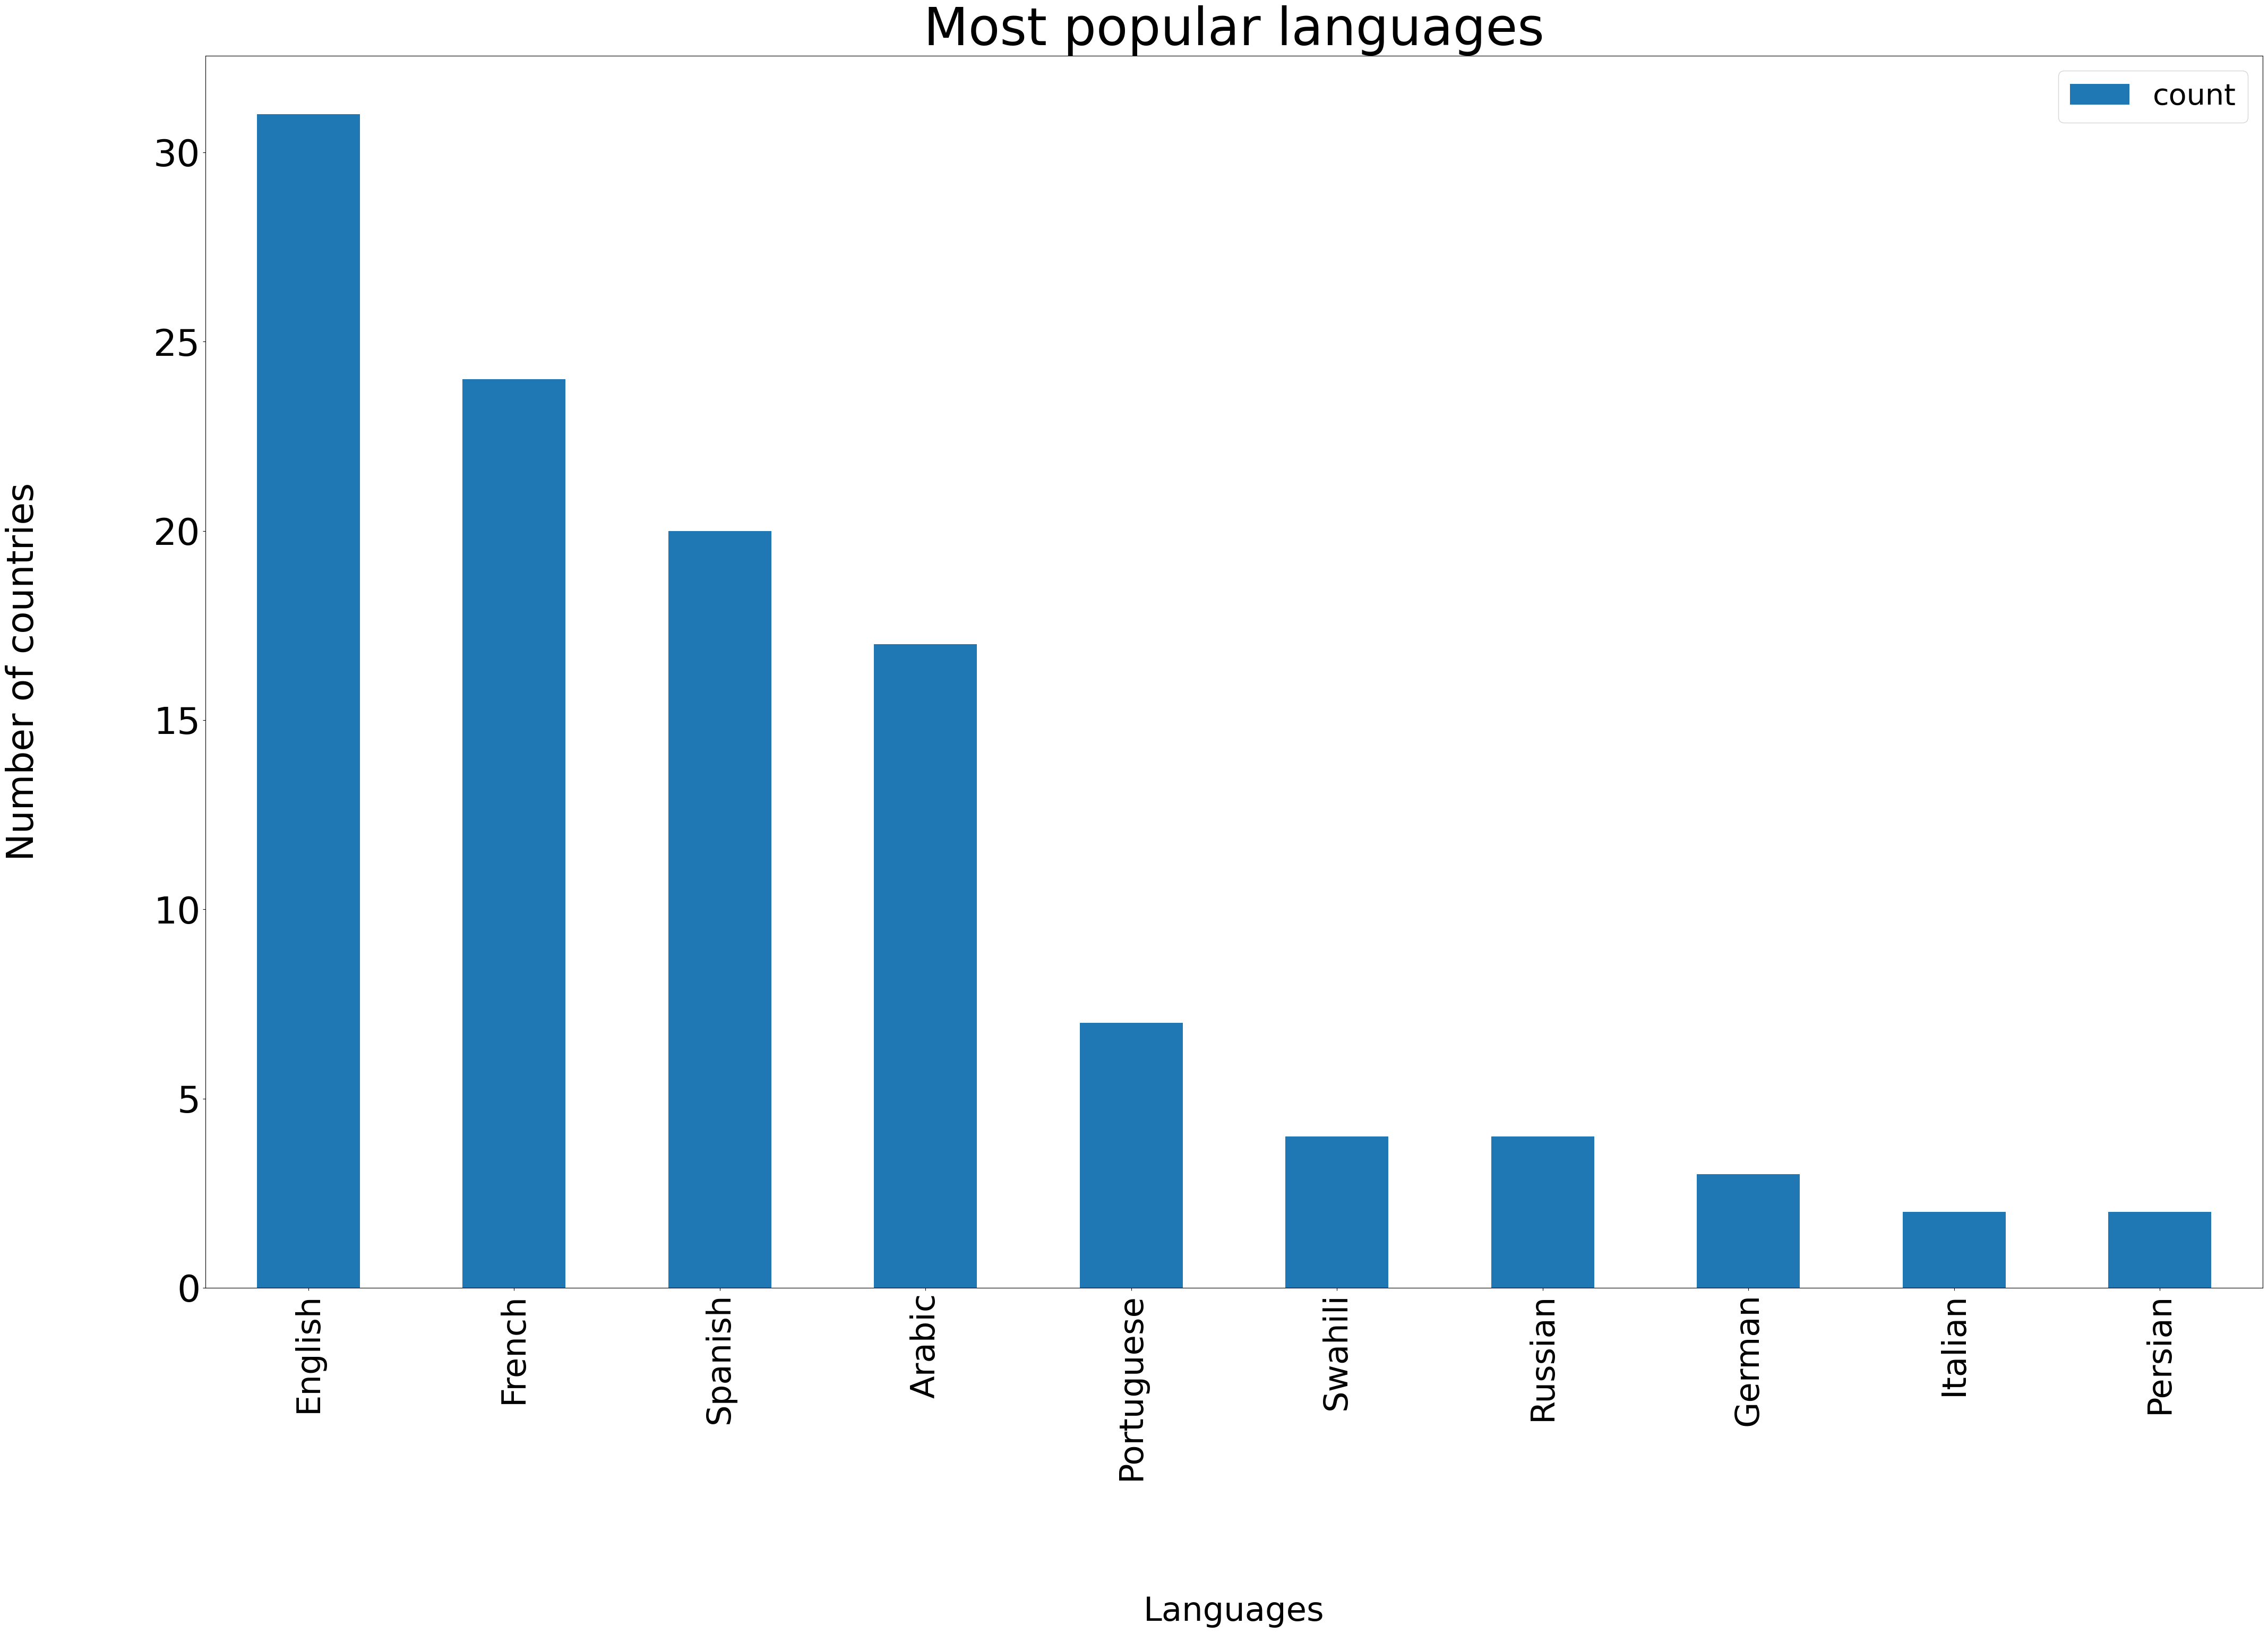

In [26]:
fig,ax = plt.subplots(figsize=(50,40))
top_10_languages.plot(kind='bar',ax=ax)

ax.yaxis.set_major_formatter('{x:,.0f}')

plt.ylabel('Number of countries',fontsize=50)
plt.xlabel('Languages',fontsize=45)

ax.yaxis.set_label_coords(-0.08,0.5)
ax.xaxis.set_label_coords(0.5,-0.25)

ax.legend(fontsize=40)

plt.xticks(fontsize=45)
plt.yticks(fontsize=50)

plt.subplots_adjust(bottom=0.3)

ax.set_title("Most popular languages", fontsize=70)



plt.show()

In [27]:
def get_top3(df, language):
    def top(df):
        return df.sort_values(by='Population', ascending=False)[:10]
    
    return df[df['Official language'] == language].groupby('Official language').apply(top).reset_index(drop=True)


top_english_countries = get_top3(df, 'English')
# top_spanish_countries = get_top3(your_dataframe, 'Spanish')
# top_french_countries = get_top3(your_dataframe, 'French')

In [28]:
vis = top_english_countries.pivot_table('Population',index='Country',columns='Continent',aggfunc=sum).T
vis.fillna(0,inplace=True)


KeyError: 'Continent'

In [ ]:
fig,ax = plt.subplots(figsize=(50,40))
vis.plot(kind='bar',stacked=True,ax=ax)

ax.yaxis.set_major_formatter('{x:,.0f}')

plt.ylabel('Population',fontsize=50)
plt.xlabel('Continents',fontsize=45)

ax.yaxis.set_label_coords(-0.15,0.5)
ax.xaxis.set_label_coords(0.5,-0.25)

ax.legend(fontsize=40)

plt.xticks(fontsize=45)
plt.yticks(fontsize=50)

plt.subplots_adjust(bottom=0.3)

ax.set_title("Countries where the official language is English", fontsize=70)



plt.show()

In [ ]:

scaler = RobustScaler()
numeric_col = df.select_dtypes(include=['number'])

In [29]:
# As we alluded to before, the ranges of the columns are all over the place. We create an instance of MinMaxScaler to bring in the ranges in between 0 and 1.
# This will help us in our modelling as something like Armed Forces size, which has values in the millions sometimes, will not have a skewed weight compared to something like Agricultural Land percentage. 
# We have done this after the visualizations, as the raw numbers there were more useful than what the scaled numbers would be. 

scaler = MinMaxScaler()

numeric_col = df.select_dtypes(include=['number'])



In [30]:
df['Density(P/km2)'] = df['Density(P/km2)'].astype(float)

KeyError: 'Density(P/km2)'

In [31]:
# Convert 'Column1' to float, skipping the first row
df['Density(P/km2)'] = pd.to_numeric(df['Density(P/km2)'], errors='coerce')

KeyError: 'Density(P/km2)'

In [32]:
df['Density(P/km2)'].unique()

KeyError: 'Density(P/km2)'

In [33]:
scaled_data = scaler.fit_transform(numeric_col)

# Replace the original numeric columns in the dataframe with the scaled data

df[numeric_col.columns] = scaled_data

In [34]:
df

,Country,Density\r\n(P/Km2),Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Capital/Major City,Co2-Emissions,CPI,CPI Change (%),...,Out of pocket health expenditure(%),Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate (%),Unemployment rate(%),Urban_population,Latitude,Longitude
0,Afghanistan,60,58.10,652230,323000,0.657510,Kabul,8672,149.9,2.30,...,78.40,0.033254,38041754,48.90,9.30,71.40,11.12,9797273,0.706944,0.687612
1,Albania,105,43.10,28748,9000,0.135585,Tirana,4536,119.05,1.40,...,56.90,0.142518,2854191,55.70,18.60,36.60,12.33,1747593,0.775091,0.553034
2,Algeria,18,17.40,2381741,317000,0.450605,Algiers,150006,151.36,2.00,...,28.10,0.204276,43053054,41.20,37.20,66.10,11.70,31510100,0.651163,0.500640
4,Angola,26,47.50,1246700,117000,0.865171,Luanda,34693,261.73,17.10,...,33.40,0.024941,31825295,77.50,9.20,49.10,6.89,21061025,0.280529,0.546539
5,Antigua and Barbuda,223,20.50,443,0,0.225050,St. John's Saint John,557,113.81,1.20,...,24.30,0.327791,97118,0,16.50,43.00,0,23800,0.547510,0.321012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,Venezuela,32,24.50,912050,343000,0.289315,Caracas,164175,2740.27,254.90,...,45.80,0.228029,28515829,59.70,0,73.30,8.80,25162368,0.447031,0.307444
191,Vietnam,314,39.30,331210,522000,0.260837,Hanoi,192668,163.52,2.80,...,43.50,0.097387,96462106,77.40,19.10,37.60,2.01,35332140,0.519148,0.802448
192,Yemen,56,44.60,527968,40000,0.606099,Sanaa,10609,157.58,8.10,...,81.00,0.036817,29161922,38.00,0,26.60,12.91,10869523,0.533264,0.633280
193,Zambia,25,32.10,752618,16000,0.750756,Lusaka,5141,212.31,9.20,...,27.50,0.141330,17861030,74.60,16.20,15.60,11.43,7871713,0.262287,0.574777


In [35]:
# This is the latest file as of 10/19/2023

In [36]:
#CHANGE MADE BY TOYOSI


In [37]:
# Get a list of column names
column_names = df.columns.tolist()

# Print the list of column names
print(column_names)

['Country', 'Density\r\n(P/Km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size', 'Birth Rate', 'Capital/Major City', 'Co2-Emissions', 'CPI', 'CPI Change (%)', 'Currency-Code', 'Fertility Rate', 'Forested Area (%)', 'Gasoline Price($)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality', 'Largest city', 'Life expectancy', 'Maternal mortality ratio', 'Minimum wage($)', 'Official language', 'Out of pocket health expenditure(%)', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate (%)', 'Unemployment rate(%)', 'Urban_population', 'Latitude', 'Longitude']


In [38]:
#'Birth Rate'
selected_features = df[['Density(P/km2)', 'Agricultural Land( %)', 'Land Area(Km2)', 'Armed Forces size',   'Co2-Emissions', 'CPI', 'CPI Change (%)',  'Fertility Rate', 'Forested Area (%)', 'Gasoline Price($)', 'GDP', 'Gross primary education enrollment (%)', 'Gross tertiary education enrollment (%)', 'Infant mortality', 'Life expectancy', 'Maternal mortality ratio', 'Minimum wage($)',  'Out of pocket health expenditure(%)', 'Physicians per thousand', 'Population', 'Population: Labor force participation (%)', 'Tax revenue (%)', 'Total tax rate (%)', 'Unemployment rate(%)', 'Urban_population',   'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 
                        'Continent_South America']]

KeyError: "['Density(P/km2)', 'Continent_Africa', 'Continent_Asia', 'Continent_Europe', 'Continent_North America', 'Continent_Oceania', 'Continent_South America'] not in index"

In [39]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(selected_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.show()

NameError: name 'selected_features' is not defined

In [40]:
k = 3  # Replace with your chosen K value
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
kmeans.fit(selected_features)

NameError: name 'selected_features' is not defined

In [41]:
cluster_labels = kmeans.labels_

AttributeError: 'KMeans' object has no attribute 'labels_'

In [42]:
df['Cluster_Labels'] = cluster_labels

NameError: name 'cluster_labels' is not defined

In [43]:
cluster_df = df[['Country','Cluster_Labels']]
cluster_df = cluster_df.sort_values(by='Cluster_Labels', ascending=False)
cluster_df

KeyError: "['Cluster_Labels'] not in index"

In [44]:
def optimize_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10,5))
    plt.plot(means,inertias,'o-')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

In [45]:
optimize_k_means(selected_features,10)

NameError: name 'selected_features' is not defined

In [46]:
for k in range(2, 10):  # Try different values of K
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(selected_features)
    silhouette_avg = silhouette_score(selected_features, cluster_labels)
    print(f"For K = {k}, the average silhouette score is: {silhouette_avg}")

NameError: name 'selected_features' is not defined

In [47]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(selected_features)

NameError: name 'selected_features' is not defined

In [48]:
for k in range(2, 10):  # Try different values of K
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(pca_data)
    silhouette_avg = silhouette_score(pca_data, cluster_labels)
    print(f"For K = {k}, the average silhouette score is: {silhouette_avg}")

NameError: name 'pca_data' is not defined

In [49]:
## Change Made by ang